In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from dask.distributed import Client
import dask
import xarray as xr
import xgcm
from dask.diagnostics import ProgressBar
import sys
import matplotlib.patches as patches
sys.path.append('/homes/metofac/wenegrat/xroms/')
#sys.path.append('/homes/metofac/wenegrat/pyspec/')

#from xroms import open_roms_netcdf_dataset
import cmocean.cm as cmo
import xroms
#from pyspec import spectrum as spec
from scipy import integrate as integrate
from timeit import default_timer as timer

#%%
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14
plt.rcParams['contour.negative_linestyle'] = 'solid'

import sys
sys.path.append("../src/")
import load_model_runs as lruns

from importlib import reload  
import time

/homes/metofac/wenegrat/xroms/xroms/interp.py:18: UserWarning: xESMF is not installed, so `interpll` will not run.
  warnings.warn("xESMF is not installed, so `interpll` will not run.")


In [4]:
## LOAD THE RUNS and THE PV FIELD
#################################
# Note that need to be careful here about getting consistent datasets (ie. all bflux etc)

# Load the raw datasets
reload(lruns)
dsWC, gridWC = lruns.newLoad('../data/model/JET_NML_CFB_BFLUX/', chunks={'time':1})

dsNC, gridNC = lruns.newLoad('../data/model/JET_NML_NOCFB_BFLUX/', chunks={'time':1})

In [5]:
# Calculate EBF fields
bx = xroms.to_rho(-9.8/1020*gridWC.derivative(dsWC.rho.isel(s_rho=-1), 'X'), gridWC)
by = xroms.to_rho(-9.8/1020*gridWC.derivative(dsWC.rho.isel(s_rho=-1), 'Y'), gridWC)
dsWC['bx'] = bx
dsWC['by'] = by
dsWC['EBF'] = ((bx*xroms.to_rho(dsWC.svstr, gridWC) - by*xroms.to_rho(dsWC.sustr, gridWC))/(dsWC.f*1020)).compute()
dsWC['EBFm'] = (bx*1e-3*7*5 - by*1e-3*7*5)/(dsWC.f*1020)
dsWC['Nablab'] = np.sqrt(bx**2 + by**2)

bx = xroms.to_rho(-9.8/1020*gridNC.derivative(dsNC.rho.isel(s_rho=-1), 'X'), gridNC)
by = xroms.to_rho(-9.8/1020*gridNC.derivative(dsNC.rho.isel(s_rho=-1), 'Y'), gridNC)
dsNC['bx'] = bx
dsNC['by'] = by
dsNC['EBF'] = ((bx*xroms.to_rho(dsNC.svstr, gridNC) - by*xroms.to_rho(dsNC.sustr, gridNC))/(dsNC.f*1020)).compute()
dsNC['Nablab'] = np.sqrt(bx**2 + by**2)



In [ ]:
# Define the frontal zones

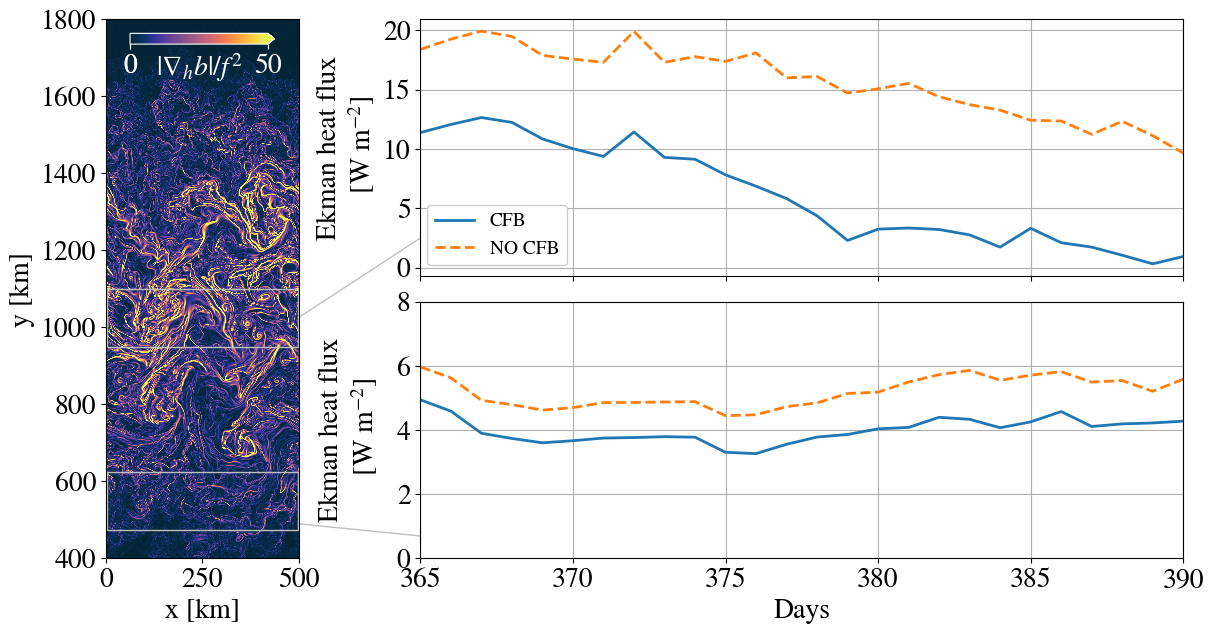

In [7]:
# Plot zooming in on the EBF and EBF'

plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 20
rs = True
# Plot Vorticity
Day = 200
Day = 360+25

startdate = 5

#fig, ax = plt.subplots(1,3, figsize=(10, 14), sharey=False)

fig = plt.figure(figsize=(15,7))
gs = fig.add_gridspec(2, 3)

templevels = np.linspace(15, 24, 10)
## Large Map
###################################
axMap = fig.add_subplot(gs[:, 0])
btowatts=(1020*4000)/(2e-4*9.8)
vl = 0
vr = 50
EBF = (dsWC.EBF)
# ix = axMap.pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, dsWC.temp.isel(s_rho=-1).sel(ocean_time=Day*86400),vmin=vl, vmax=vr, cmap='viridis', rasterized=rs)
# ix = axMap.pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBF.sel(ocean_time=Day*86400), vmin=vl, vmax=vr, cmap = cmo.balance_r, rasterized=rs)
ix = axMap.pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, dsWC.Nablab.sel(ocean_time=Day*86400)/dsWC.f**2, vmin=vl, vmax=vr, cmap = cmo.thermal, rasterized=rs)

# axMap.contour(dsWC.x_rho/1000, dsWC.y_rho/1000, dsWC.temp.isel(s_rho=-1).sel(ocean_time=Day*86400),levels = templevels, colors='0.75', alpha=0.75, linewidths=0.5)

label=r'SST [$^\circ$ C]'
axMap.set_ylim(400, 1800)
axMap.set_aspect('equal')

axMap.set_ylim(400, 1800)
axMap.set_aspect('equal')

# axins = inset_axes(axMap,
#                     width="75%",  # width = 50% of parent_bbox width
#                     height="2%",  # height : 5%
#                     loc='lower center')
# cb = plt.colorbar(ix, ax=axMap, cax=axins, orientation='horizontal', extend='both', ticks=[vl, 0, vr])
# cb.set_label(label)
# cb.ax.xaxis.set_ticks_position('top')
# cb.ax.xaxis.set_label_position('top')
axMap.set_xticks([0, 250, 500])
 
axMap.set_ylabel('y [km]')
axMap.set_xlabel('x [km]')
# axMap.set_title('Horizontal buoyancy gradient')
# axMap.annotate(r'${\overline{\tau}}$', (300, 1775), (175, 1650), arrowprops = 
#                dict(arrowstyle='fancy', 
#                     fc='0.8',
#                     ec = 'k' ),
#               color='k')

axins = inset_axes(axMap,
                    width="75%",  # width = 50% of parent_bbox width
                    height="2%",  # height : 5%
                    loc='upper center')
cb = plt.colorbar(ix, ax=axMap, cax=axins, orientation='horizontal', extend='max', ticks=[vl, 0, vr])
cb.set_label('$|\\nabla_h b|/f^2$', labelpad=-20, color='w')
# set colorbar tick color
cb.ax.xaxis.set_tick_params(color='w')
# set colorbar edgecolor 
cb.outline.set_edgecolor('w')
# set colorbar ticklabels
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color='w')


# cb.ax.xaxis.set_ticks_position('top')
# cb.ax.xaxis.set_label_position('top')
    
## First zoom
###################################
axTOP = fig.add_subplot(gs[0, 1:])
btowatts=(1020*4000)/(2e-4*9.8)
yl = slice(1900, 2200) #SZ

xlim = (0, 500)
ylim = (0.5*1900, 0.5*2200)
rect = patches.Rectangle( (xlim[0]+1, ylim[0]), xlim[1]-xlim[0]-2, ylim[1]-ylim[0], edgecolor= '0.75', facecolor='none')
axMap.add_patch(rect)

axTOP.plot(dsWC.time[startdate:]/86400, btowatts*dsWC.EBF.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))[startdate:], linewidth=2, label='CFB')
axTOP.plot(dsNC.time[startdate:]/86400, btowatts*dsNC.EBF.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))[startdate:], label='NO CFB', linestyle='--', linewidth=2)

axTOP.set_xlim(365, 390)
# This checks the meean EBF in the CFB run
# ax[0].plot(dsWC.time[startdate:]/86400, btowatts*dsWC.EBFm.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))[startdate:], linewidth=2, label='CFB-M')

axTOP.grid()
axTOP.set_ylabel('Ekman heat flux\n [W m$^{-2}$]')
axTOP.set_xticklabels([])
## ADD CONNECTION LINES
con = patches.ConnectionPatch(xyA=[xlim[1]-1,0.5*(ylim[0]+ylim[1])], xyB=[365,2.5], coordsA="data", coordsB="data",
                      axesA=axMap, axesB=axTOP, color='0.75')
axMap.add_artist(con)


### DO IT AGAIN FOR THE OTHER PATCH
###################################
axBTM = fig.add_subplot(gs[1, 1:])
btowatts=(1020*4000)/(2e-4*9.8)
yl = slice(950, 1250) #WZ

axBTM.plot(dsWC.time[startdate:]/86400, btowatts*dsWC.EBF.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))[startdate:], linewidth=2, label='CFB')
axBTM.plot(dsNC.time[startdate:]/86400, btowatts*dsNC.EBF.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))[startdate:], label='NO CFB', linestyle='--', linewidth=2)

# This checks the meean EBF in the CFB run
# ax[0].plot(dsWC.time[startdate:]/86400, btowatts*dsWC.EBFm.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))[startdate:], linewidth=2, label='CFB-M')

xlim = (0, 500)
ylim = (0.5*950, 0.5*1250)

axBTM.grid()
axBTM.set_ylabel('Ekman heat flux\n [W m$^{-2}$]', labelpad=12)
axBTM.set_xlim(365, 390)
axBTM.set_ylim(0, 8)
axBTM.set_xlabel('Days')
# Add the box on the main plot
rect = patches.Rectangle( (xlim[0]+1, ylim[0]), xlim[1]-xlim[0]-2, ylim[1]-ylim[0], edgecolor= '0.75', facecolor='none')
axMap.add_patch(rect)

# ## ADD CONNECTION LINES
con = patches.ConnectionPatch(xyA=[xlim[1]-1,(ylim[0]+15)], xyB=[365,0.7], coordsA="data", coordsB="data",
                      axesA=axMap, axesB=axBTM, color='0.75')
axMap.add_artist(con)
# con = patches.ConnectionPatch(xyA=[xlim[1],ylim[0]], xyB=[xlim[0],ylim[0]], coordsA="data", coordsB="data",
#                       axesA=axMap, axesB=axBTM, color='k')
# axMap.add_artist(con)

### ADD COLORBAR
# fig.subplots_adjust(right=0.975)
# cbar_ax = fig.add_axes([0.98, 0.25, 0.0125, 0.5])
# cb = fig.colorbar(ix, cax=cbar_ax, extend='both', ticks=[-500, 0, 500])
# cb.set_label('$W/m^2$')
# cb.solids.set_edgecolor("face")

## FINAL CLEAN UP AND SAVING
plt.rcParams['font.size'] = 14
plt.subplots_adjust(wspace=0.07, hspace=0.1)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

axTOP.legend(bbox_to_anchor=(0.205, 0.315), ncol=1, framealpha=1)

#Add scale bar
##############
# rect = patches.Rectangle((xlim[0], ylim[0]-5), 20, 3, linewidth=1, edgecolor='0.5', facecolor='0.5', clip_on=False)
# Add the patch to the Axes
# axZ2.add_patch(rect)

# axZ2.annotate('20 km', xy=(xlim[0]+5, ylim[0]-8),  xycoords='data',
#              xytext=(xlim[0]+2, ylim[0]-11), textcoords='data',
#               color='0.5', fontsize=12,
# #              arrowprops=dict(arrowstyle='-', facecolor='black'),
#               annotation_clip=False
#              )

# plt.savefig('EBFregions.pdf', bbox_inches='tight', dpi=350)

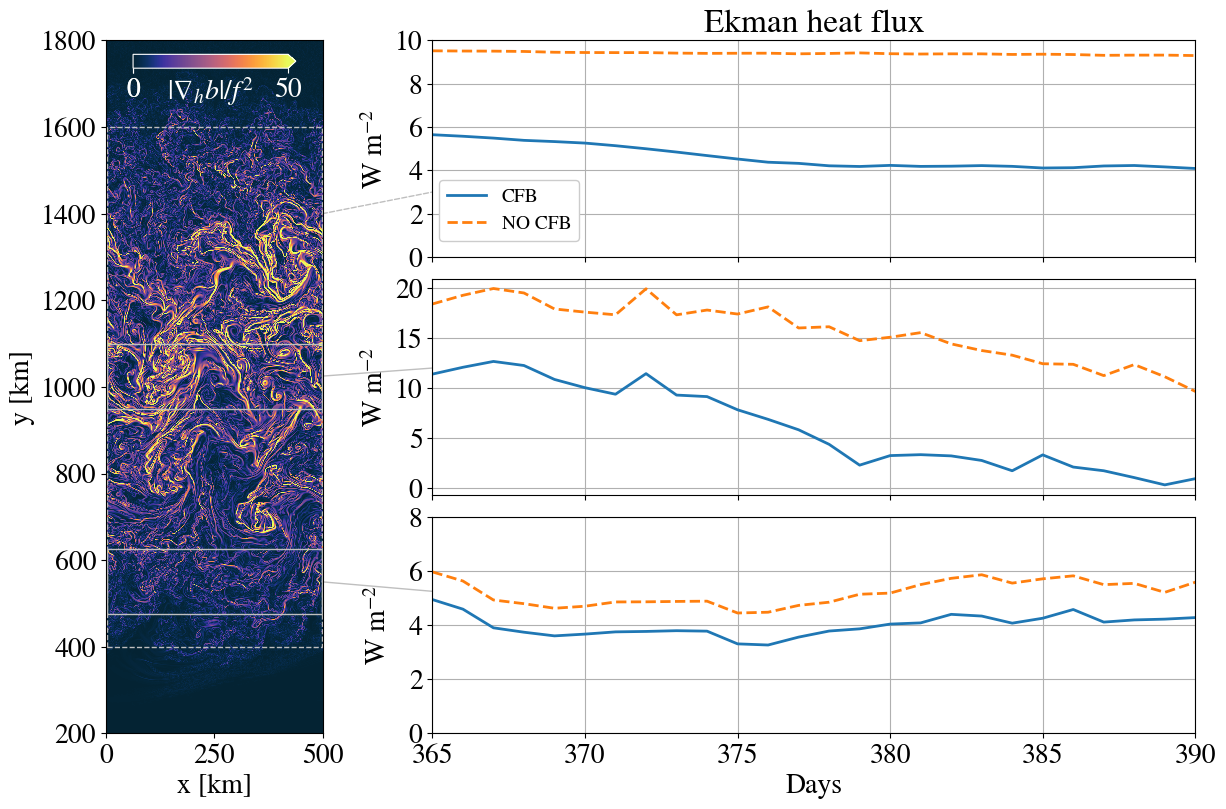

In [46]:
# THREE REGION PLOT
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 20
rs = True
# Plot Vorticity
Day = 200
Day = 360+25

startdate = 5

#fig, ax = plt.subplots(1,3, figsize=(10, 14), sharey=False)

fig = plt.figure(figsize=(15,9))
gs = fig.add_gridspec(3, 3)

templevels = np.linspace(15, 24, 10)
## Large Map
###################################
axMap = fig.add_subplot(gs[:, 0])
btowatts=(1020*4000)/(2e-4*9.8)
vl = 0
vr = 50
EBF = (dsWC.EBF)
# ix = axMap.pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, dsWC.temp.isel(s_rho=-1).sel(ocean_time=Day*86400),vmin=vl, vmax=vr, cmap='viridis', rasterized=rs)
# ix = axMap.pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBF.sel(ocean_time=Day*86400), vmin=vl, vmax=vr, cmap = cmo.balance_r, rasterized=rs)
ix = axMap.pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, dsWC.Nablab.sel(ocean_time=Day*86400)/dsWC.f**2, vmin=vl, vmax=vr, cmap = cmo.thermal, rasterized=rs)

# axMap.contour(dsWC.x_rho/1000, dsWC.y_rho/1000, dsWC.temp.isel(s_rho=-1).sel(ocean_time=Day*86400),levels = templevels, colors='0.75', alpha=0.75, linewidths=0.5)

label=r'SST [$^\circ$ C]'
axMap.set_ylim(200, 1800)
axMap.set_aspect('equal')

# axMap.set_ylim(400, 1800)
# axMap.set_aspect('equal')

# axins = inset_axes(axMap,
#                     width="75%",  # width = 50% of parent_bbox width
#                     height="2%",  # height : 5%
#                     loc='lower center')
# cb = plt.colorbar(ix, ax=axMap, cax=axins, orientation='horizontal', extend='both', ticks=[vl, 0, vr])
# cb.set_label(label)
# cb.ax.xaxis.set_ticks_position('top')
# cb.ax.xaxis.set_label_position('top')
axMap.set_xticks([0, 250, 500])
 
axMap.set_ylabel('y [km]')
axMap.set_xlabel('x [km]')
# axMap.set_title('Horizontal buoyancy gradient')
# axMap.annotate(r'${\overline{\tau}}$', (300, 1775), (175, 1650), arrowprops = 
#                dict(arrowstyle='fancy', 
#                     fc='0.8',
#                     ec = 'k' ),
#               color='k')

axins = inset_axes(axMap,
                    width="75%",  # width = 50% of parent_bbox width
                    height="2%",  # height : 5%
                    loc='upper center')
cb = plt.colorbar(ix, ax=axMap, cax=axins, orientation='horizontal', extend='max', ticks=[vl, 0, vr])
cb.set_label('$|\\nabla_h b|/f^2$', labelpad=-20, color='w')
# set colorbar tick color
cb.ax.xaxis.set_tick_params(color='w')
# set colorbar edgecolor 
cb.outline.set_edgecolor('w')
# set colorbar ticklabels
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color='w')


# cb.ax.xaxis.set_ticks_position('top')
# cb.ax.xaxis.set_label_position('top')
    
    
## Full region
###################################
axFULL = fig.add_subplot(gs[0, 1:])
btowatts=(1020*4000)/(2e-4*9.8)
yl = slice(800, 3200) #SZ

xlim = (0, 500)
ylim = (0.5*800, 0.5*3200)
rect = patches.Rectangle( (xlim[0]+1, ylim[0]), xlim[1]-xlim[0]-2, ylim[1]-ylim[0], edgecolor= '0.75',linestyle='dashed', facecolor='none')
axMap.add_patch(rect)

axFULL.plot(dsWC.time[startdate:]/86400, btowatts*dsWC.EBF.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))[startdate:], linewidth=2, label='CFB')
axFULL.plot(dsNC.time[startdate:]/86400, btowatts*dsNC.EBF.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))[startdate:], label='NO CFB', linestyle='--', linewidth=2)

axFULL.set_xlim(365, 390)
axFULL.set_ylim(0, 10)
axFULL.set_title('Ekman heat flux')
# This checks the meean EBF in the CFB run
# ax[0].plot(dsWC.time[startdate:]/86400, btowatts*dsWC.EBFm.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))[startdate:], linewidth=2, label='CFB-M')

axFULL.grid()
axFULL.set_ylabel('W m$^{-2}$')
axFULL.set_xticklabels([])
## ADD CONNECTION LINES
con = patches.ConnectionPatch(xyA=[xlim[1]-1,1400], xyB=[365,3], coordsA="data", coordsB="data",
                      axesA=axMap, axesB=axFULL, color='0.75', linestyle='dashed')
axMap.add_artist(con)

## First zoom
###################################
axTOP = fig.add_subplot(gs[1, 1:])
btowatts=(1020*4000)/(2e-4*9.8)
yl = slice(1900, 2200) #SZ

xlim = (0, 500)
ylim = (0.5*1900, 0.5*2200)
rect = patches.Rectangle( (xlim[0]+1, ylim[0]), xlim[1]-xlim[0]-2, ylim[1]-ylim[0], edgecolor= '0.75', facecolor='none')
axMap.add_patch(rect)

axTOP.plot(dsWC.time[startdate:]/86400, btowatts*dsWC.EBF.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))[startdate:], linewidth=2, label='CFB')
axTOP.plot(dsNC.time[startdate:]/86400, btowatts*dsNC.EBF.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))[startdate:], label='NO CFB', linestyle='--', linewidth=2)

axTOP.set_xlim(365, 390)
# This checks the meean EBF in the CFB run
# ax[0].plot(dsWC.time[startdate:]/86400, btowatts*dsWC.EBFm.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))[startdate:], linewidth=2, label='CFB-M')

axTOP.grid()
axTOP.set_ylabel('W m$^{-2}$')
axTOP.set_xticklabels([])
## ADD CONNECTION LINES
con = patches.ConnectionPatch(xyA=[xlim[1]-1,0.5*(ylim[0]+ylim[1])], xyB=[365,12], coordsA="data", coordsB="data",
                      axesA=axMap, axesB=axTOP, color='0.75')
axMap.add_artist(con)


### DO IT AGAIN FOR THE OTHER PATCH
###################################
axBTM = fig.add_subplot(gs[2, 1:])
btowatts=(1020*4000)/(2e-4*9.8)
yl = slice(950, 1250) #WZ

axBTM.plot(dsWC.time[startdate:]/86400, btowatts*dsWC.EBF.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))[startdate:], linewidth=2, label='CFB')
axBTM.plot(dsNC.time[startdate:]/86400, btowatts*dsNC.EBF.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))[startdate:], label='NO CFB', linestyle='--', linewidth=2)

# This checks the meean EBF in the CFB run
# ax[0].plot(dsWC.time[startdate:]/86400, btowatts*dsWC.EBFm.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))[startdate:], linewidth=2, label='CFB-M')

xlim = (0, 500)
ylim = (0.5*950, 0.5*1250)

axBTM.grid()
axBTM.set_ylabel('W m$^{-2}$', labelpad=12)
axBTM.set_xlim(365, 390)
axBTM.set_ylim(0, 8)
axBTM.set_xlabel('Days')
# Add the box on the main plot
rect = patches.Rectangle( (xlim[0]+1, ylim[0]), xlim[1]-xlim[0]-2, ylim[1]-ylim[0], edgecolor= '0.75', facecolor='none')
axMap.add_patch(rect)

# ## ADD CONNECTION LINES
con = patches.ConnectionPatch(xyA=[xlim[1]-1,0.5*(ylim[0]+ylim[1])], xyB=[365,5.25], coordsA="data", coordsB="data",
                      axesA=axMap, axesB=axBTM, color='0.75')
axMap.add_artist(con)
# con = patches.ConnectionPatch(xyA=[xlim[1],ylim[0]], xyB=[xlim[0],ylim[0]], coordsA="data", coordsB="data",
#                       axesA=axMap, axesB=axBTM, color='k')
# axMap.add_artist(con)

### ADD COLORBAR
# fig.subplots_adjust(right=0.975)
# cbar_ax = fig.add_axes([0.98, 0.25, 0.0125, 0.5])
# cb = fig.colorbar(ix, cax=cbar_ax, extend='both', ticks=[-500, 0, 500])
# cb.set_label('$W/m^2$')
# cb.solids.set_edgecolor("face")

## FINAL CLEAN UP AND SAVING
plt.rcParams['font.size'] = 14
plt.subplots_adjust(wspace=0.07, hspace=0.1)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# axTOP.legend(bbox_to_anchor=(0.205, 0.315), ncol=1, framealpha=1)
axFULL.legend(bbox_to_anchor=(0.205, 0.4), ncol=1, framealpha=1)

#Add scale bar
##############
# rect = patches.Rectangle((xlim[0], ylim[0]-5), 20, 3, linewidth=1, edgecolor='0.5', facecolor='0.5', clip_on=False)
# Add the patch to the Axes
# axZ2.add_patch(rect)

# axZ2.annotate('20 km', xy=(xlim[0]+5, ylim[0]-8),  xycoords='data',
#              xytext=(xlim[0]+2, ylim[0]-11), textcoords='data',
#               color='0.5', fontsize=12,
# #              arrowprops=dict(arrowstyle='-', facecolor='black'),
#               annotation_clip=False
#              )

#plt.savefig('../figures/EBFregions_all.pdf', bbox_inches='tight', dpi=350)

In [ ]:
# Fancy EBF plots NO PV
plt.rcParams['text.usetex'] = True
rs = True
# Plot Vorticity
Day = 380
#Day = 185
#Day = 360+30
#fig, ax = plt.subplots(1,3, figsize=(10, 14), sharey=True, dpi=300)
fig = plt.figure(figsize=(10*1.1,2.2*1.07), dpi=200)
btowatts=(1020*4000)/(2e-4*9.8)
# Divergence
#divnorm = dsWC.div.isel(s_rho=-3).sel(ocean_time=Day*86400)/dsWC.f
#ax[2].pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, divnorm, vmin=-1, vmax=1, cmap = cmo.curl)

#ax[2].set_ylim(300, 1900)
#ax[2].set_aspect('equal')
#yl = slice(600*2, 1600*2)
ny = np.array(dsWC.eta_rho.size)
nyc = int(ny/2)
nysp = int(ny/8)
yl = slice(nyc-nysp, nyc+nysp)

# Iterate through subplots

vl = -500
vr = 500
ax = plt.subplot2grid((1,3), (0,0), rowspan = 1, colspan=1)
ix = ax.pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*dsWC.EBF.sel(ocean_time=Day*86400), vmin=vl, vmax=vr, cmap = cmo.balance_r, rasterized=rs)
label=r'W m$^{-2}$'
   
ax.set_ylim(800, 1300)
ax.set_xlim(0, 500)
ax.set_aspect('equal')
ax.set_title('Ekman heat flux')

cb = plt.colorbar(ix, ax=ax, extend='both', ticks=[vl, 0, vr])

ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')


ax = plt.subplot2grid((1,3), (0,1), rowspan = 1, colspan=2)
EBF_WC = dsWC.EBF.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))
EBF_NC = dsNC.EBF.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))
EBF_WC_M = dsWC.EBFm.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))

ax.plot(dsWC.ocean_time[1:]/86400, EBF_WC[1:]*btowatts, linewidth=2, label='CFB')
ax.plot(dsWC.ocean_time[1:]/86400, EBF_WC_M[1:]*btowatts, linewidth=2, label='CFB - Mean')
ax.plot(dsNC.ocean_time[1:]/86400, EBF_NC[1:]*btowatts, linewidth=2, linestyle='--', label='NO CFB')
ax.grid()
ax.set_ylim(0, 15)
ax.set_ylabel('W m$^{-2}$', labelpad=10)
#ax.set_xlim(165, 200)
#ax.set_xticklabels([])
ax.set_xlabel('Days')
#ax.text(165.75, 1.1 ,'b)', color='k', size=14, bbox=dict(facecolor='w', edgecolor='k'))
ax.legend()
ax.set_title('Domain averaged Ekman heat flux')
plt.subplots_adjust( wspace = 0.4)
#plt.tight_layout()
# plt.savefig('../figures/EBFPanelsNOPV_BFLUX.pdf', bbox_inches='tight', dpi=300)
#plt.rcParams['text.usetex'] = False